In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import math

In [2]:
def f(x):
    return x*x

In [3]:
domain = np.arange(-10, 10, 0.01)
image = f(domain)

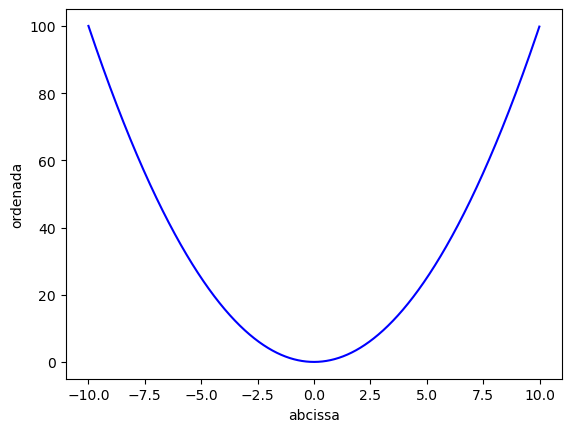

In [4]:
plt.plot(domain, image, color='blue')
plt.xlabel("abcissa")
plt.ylabel("ordenada")
plt.show()

In [6]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        dot.node(name=uid, label=f"{node.label} | data {node.data:.2f} | grad {node.grad:.2f}", shape='record')
        if node._op:
            dot.node(name=uid+node._op, label=node._op)
            dot.edge(uid+node._op, uid)
        
    for edge1, edge2 in edges:
        dot.edge(str(id(edge1)), str(id(edge2))+edge2._op)

    return dot

In [191]:
class ValueObj:
    def __init__(self, data, _children=(), _op='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self) -> str:
        return f"Data value: {self.data} | Grad: {self.grad}"
    
    def __add__(self, other) -> "ValueObj":
        output = ValueObj(self.data + other.data, (self, other), 'add')
        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
        output._backward = _backward
        return output
    
    def __mul__(self, other) -> "ValueObj":
       output = ValueObj(other.data * self.data, (self, other), 'multiplying')
       def _backward():
           self.grad += other.data * output.grad
           other.grad += self.data * output.grad
       output._backward = _backward
       return output

    def tanh(self) -> "ValueObj":
        output = ValueObj(math.tanh(self.data), (self,), _op="tanh")
        def _backward():
            self.grad = (1 - math.pow(math.tanh(self.data), 2)) * output.grad
        output._backward = _backward
        return output

In [196]:
input1 = ValueObj(2.223)
input2 = ValueObj(-3.957)

weight1 = ValueObj(0.574)
weight2 = ValueObj(0.8112)

bias1 = ValueObj(5.552)

hidden1 = (input1*weight1) + (input2*weight2) + bias1
hidden2 = (input1*weight1) + (input2*weight2) + bias1

weight3 = ValueObj(0.661)
weight4 = ValueObj(1.928)

bias2 = ValueObj(2.0)

sumTotal = (hidden1*weight3) + (hidden2*weight4) + bias2
output = sumTotal.tanh()
output

Data value: 0.9999999997323363 | Grad: 0.0

In [199]:
print(output)
print(sumTotal)
print(bias2)
print(hidden1)
print(hidden2)
print(weight3)
print(weight4)
print(bias1)
print(input1)
print(input2)
print(weight1)
print(weight2)

Data value: 0.9999999997323363 | Grad: 1.0
Data value: 11.367218440399999 | Grad: 5.35327338013758e-10
Data value: 2.0 | Grad: 1.070654676027516e-09
Data value: 3.6180835999999994 | Grad: 2.8308109634167524e-09
Data value: 3.6180835999999994 | Grad: 4.128444430762102e-09
Data value: 0.661 | Grad: 1.549487249839387e-08
Data value: 1.928 | Grad: 7.747436249196936e-09
Data value: 5.552 | Grad: 6.9592553941788546e-09
Data value: 2.223 | Grad: 6.364339699516108e-09
Data value: -3.957 | Grad: 1.798868419598421e-08
Data value: 0.574 | Grad: 2.464795671084374e-08
Data value: 0.8112 | Grad: -8.774805641458272e-08


In [198]:
backprop(output)

In [183]:
def backprop(output: ValueObj):
    topo = list()
    visited = set()
    def build_topolofy(v):
        if v not in visited:
            visited.add(output)
            for child in v._prev:
                build_topolofy(child)
                topo.append(v)

    build_topolofy(output)

    output.grad = 1.0
    for node in reversed(topo):
        node._backward()